# FH-PS-AOP Challenge: Fetal Head Segmentation and Angle of Progression Estimation

Anna Putina,
Universitat Politècnica De Catalunya

## Overview:

This Jupyter notebook presents a solution to the FH-PS-AOP Grand Challenge, focusing on the automatic segmentation of Fetal Head to Pubic Symphysis (FH-PS) structures in transperineal ultrasound images.

## Challenge Description:

The FH-PS-AOP Challenge aims to advance automated techniques for FH-PS segmentation, providing a benchmark dataset for objective method comparison.

## Motivation:

- **Development of Automated Techniques:** Encourage the development and application of state-of-the-art automated methods for FH-PS segmentation in transperineal ultrasound images.

- **Benchmark Dataset:** Establish a benchmark dataset for fair and transparent comparisons of different segmentation methods, contributing to advancements in biomedical image analysis.

- **AOP Estimation:** Stimulate the creation of novel, general-purpose methods for the estimation of the Angle of Progression (AOP) in the context of fetal head descent.

## Implementation:

This notebook provides a step-by-step solution to the challenge using the Colab environment. It includes data preprocessing, model development, training, and evaluation on Training Set. The final model can be exported for integration into a Docker container, aligning with the challenge guidelines.

## Imports

Installing the necessary libraries

In [1]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=16d63344b17c2b7c44990f911201282936d42d7871e7ee4d563670900e7a58e5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=2147359d0c20f7996a01fbd7867548fe98aefd25d6ed2f1c4e577e90295fcd34
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install torchinfo

In [3]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.5 MB/s eta 0:00:00


In [4]:
#Import libraries
import os
import glob
import random
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Image manipulation
from PIL import Image
import cv2

import SimpleITK as sitk
from skimage.util import montage as montage2d

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import save_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss, SoftBCEWithLogitsLoss

Secondary functions such as training, calculating metrics, and plotting have been moved to separate files to avoid cluttering the code. To use them, one need to upload them to Colab.

In [102]:
# From local helper files
from evaluation import compute_accuracy_loss
from metrics import check_metrics
from train import train_model
from plotting import plot_loss_accuracy,  plot_img_mask_pred
from aop_estimation import angle_of_progression_estimation

## Parameters

Parameters for dataloaders, model training, saving and loading

In [7]:
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
NUM_EPOCHS = 10
NUM_WORKERS = 4
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [8]:
DEVICE

device(type='cuda')

## Data loading

To upload the data, first one should upload both folders (one with images and another with masks) to Google Drive, and then mount Google Drive to Colab.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, the names of the directories for images and ground truth are specified.

In [10]:
# Define the base directory where images and ground truth data are stored
base_dir = '/content/drive/My Drive/'

challenge_folder = "Pubic Symphysis-Fetal Head Segmentation and Angle of Progression/"

# Define the subdirectories for images and ground truth
image_folder = challenge_folder + "image_mha/"
gt_folder = challenge_folder + "label_mha/"

In [11]:
# Combine the base directory with subdirectories
image_dir = os.path.join(base_dir, image_folder)
gt_dir = os.path.join(base_dir, gt_folder)

# Get paths to the training and target images
image_paths = sorted([os.path.join(image_dir, fname)
                      for fname in os.listdir(image_dir)
                      if fname.endswith(".mha")])
gt_paths = sorted([os.path.join(gt_dir, fname)
                    for fname in os.listdir(gt_dir)
                    if fname.endswith(".mha")])

# Check if dimensions are equal
print("Number of samples in the image folder:", len(image_paths))
print("Number of samples in the mask folder:", len(gt_paths))

Number of samples in the image folder: 4000
Number of samples in the mask folder: 4000


## Visualisation of an image with its corresponding mask

In [ ]:
image = sitk.ReadImage(base_dir + image_folder + '00001.mha')

In [ ]:
# Image characteristics
print(image.GetDimension())
print(image.GetWidth())
print(image.GetHeight())
print(image.GetSize())
print(image.GetNumberOfComponentsPerPixel())
print(image.GetDepth())

3
256
256
(256, 256, 3)
1
3


In [ ]:
# Conversion between numpy and SimpleITK
np_image = sitk.GetArrayFromImage(image)
print(np_image.shape)

(3, 256, 256)


In [ ]:
image_xslice = sitk.GetArrayViewFromImage(image)[0,:,:]
image_yslice = sitk.GetArrayViewFromImage(image)[1,:,:]
image_zslice = sitk.GetArrayViewFromImage(image)[2,:,:]

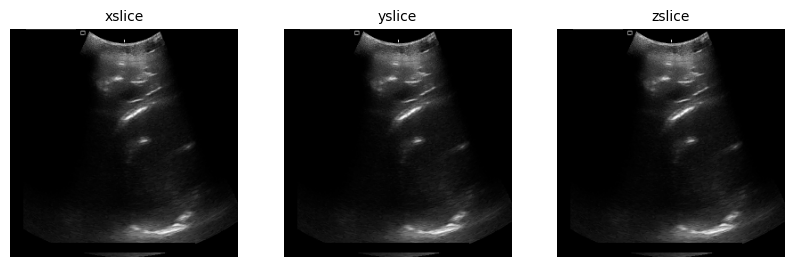

In [ ]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(image_xslice, cmap='gray')
plt.title('xslice', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(image_yslice, cmap='gray');
plt.title('yslice', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('zslice', fontsize=10)
plt.imshow(image_zslice, cmap='gray')
plt.axis('off');

In [ ]:
mask = sitk.ReadImage(base_dir + gt_folder + '00001.mha')

In [ ]:
# Mask characteristics
print(mask.GetDimension())
print(mask.GetWidth())
print(mask.GetHeight())
print(mask.GetSize())
print(mask.GetNumberOfComponentsPerPixel())
print(mask.GetDepth())

2
256
256
(256, 256)
1
0


In [ ]:
# Conversion between numpy and SimpleITK
mask_xslice = sitk.GetArrayViewFromImage(mask)

(-0.5, 255.5, 255.5, -0.5)

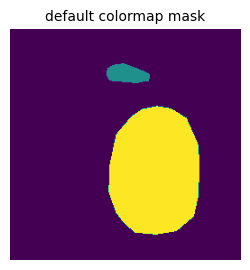

In [ ]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,1,1)
plt.imshow(mask_xslice)
plt.title('default colormap mask', fontsize=10)
plt.axis('off')

In [ ]:
def image_reader(img_path, isMask):
  img = sitk.ReadImage(img_path)
  np_image = sitk.GetArrayFromImage(img)

  if isMask:
    img_rgb = Image.fromarray(np_image,'L')
    img_array = np_image
  else:
    img_array = np.transpose(np_image, (1,2,0))
    img_rgb = Image.fromarray(img_array,'RGB')

  return img_rgb, img_array

In [ ]:
index = 100

In [ ]:
image, img_np = image_reader(base_dir + image_folder + f'{index:05d}.mha', False)
mask, mask_np = image_reader(base_dir + gt_folder + f'{index:05d}.mha', True)

(-0.5, 255.5, 255.5, -0.5)

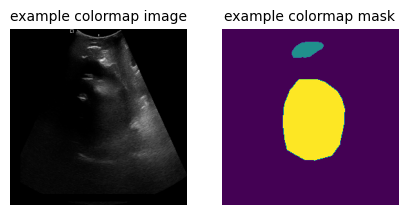

In [ ]:
# Showing image and mask in the same plot
fig = plt.figure(figsize=(5,5))

fig.add_subplot(1,2,1)
plt.imshow(img_np)
plt.title('example colormap image', fontsize=10)
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(mask_np);
plt.title('example colormap mask', fontsize=10)
plt.axis('off')

In [ ]:
# Isolating FH, PS, and background in the mask
mask_tensor = torch.tensor(mask_np)
mask_dict = {0:'background', 1: 'PS', 2:'FH'}
mask_np = mask_tensor.type(torch.LongTensor)
main_mask = F.one_hot(mask_np, len(mask_dict))
main_mask = np.asarray(main_mask)
main_mask.shape

(256, 256, 3)

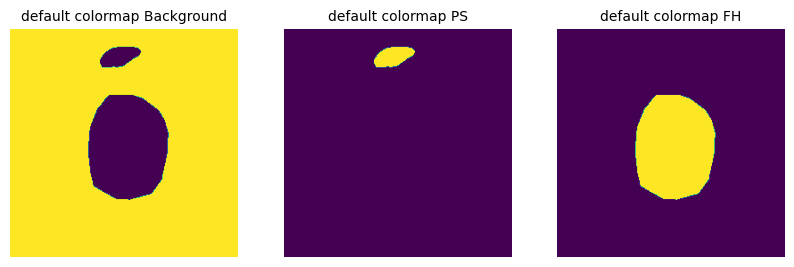

In [ ]:
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(main_mask[:,:,0])
plt.title('default colormap Background', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(main_mask[:,:,1]);
plt.title('default colormap PS', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('default colormap FH', fontsize=10)
plt.imshow(main_mask[:,:,2])
plt.axis('off');

## Creating datasets and dataloaders

Initially, we divide the dataset into training, validation, and test sets.

In [12]:
percentage_test = 0.1
percentage_validation = 0.15

# Set your random seed for reproducibility
random_seed = 142

# Split your data into training, validation, and test sets
image_paths_trainval, image_paths_test, mask_paths_trainval, mask_paths_test = train_test_split(image_paths, gt_paths, test_size=percentage_test, random_state=random_seed)
image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(image_paths_trainval, mask_paths_trainval, test_size=percentage_validation, random_state=random_seed)

Classes in the ground truth mask

In [42]:
CLASSES = ['background', 'PS', 'FH']

Image and mask transform operations

 Image data augmentation is performed using the Albumentations library as part of the preprocessing pipeline. Two sets of augmentation operations were defined: `train_transform` for training images and `val_transform` for validation images. The `train_transform` included resizing, random rotations, horizontal flips, and pixel value normalization, with the aim of enhancing the diversity of the training data and improving the model's generalization ability. On the other hand, the `val_transform` focused primarily on resizing and normalization to ensure consistency in the validation set.

In [14]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.CoarseDropout(
            max_holes = 4, # Maximum number of regions to zero out. (default: 8)
            max_height = 4, # Maximum height of the hole. (default: 8)
            max_width = 4, # Maximum width of the hole. (default: 8)
            min_holes=None, # Minimum number of regions to zero out. (default: None, which equals max_holes)
            min_height=None, # Minimum height of the hole. (default: None, which equals max_height)
            min_width=None, # Minimum width of the hole. (default: None, which equals max_width)
            fill_value=0, # Value for dropped pixels.
            mask_fill_value=None, # Fill value for dropped pixels in mask.
            always_apply=False,
            p=0.5
            ),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [15]:
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

**Dataset Class**

The mask is divided into three parts, all contained within the same torch tensor, which is responsible for the background, pubic symphysis, and fetal head.

In [16]:
def image_reader(img_path, isMask):
  img = sitk.ReadImage(img_path)
  np_image = sitk.GetArrayFromImage(img)

  if isMask:
    img_rgb = Image.fromarray(np_image,'L')
    img_array = np_image
  else:
    img_array = np.transpose(np_image, (1,2,0))
    img_rgb = Image.fromarray(img_array,'RGB')

  return img_rgb, img_array

In [17]:
class HeadSymphysisDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        mask_name = self.mask_paths[idx]

        _, img = image_reader(img_name, False)
        _, mask = image_reader(mask_name, True)

        if self.transform:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]

        mask = mask.type(torch.LongTensor)
        mask_onehot = F.one_hot(mask, len(CLASSES))
        mask_stack = torch.stack((mask_onehot[:,:,0], mask_onehot[:,:,1], mask_onehot[:,:,2]))
        mask_stack = mask_stack.type(torch.IntTensor)

        return img, mask_stack

In [18]:
train_dataset = HeadSymphysisDataset(image_paths_train, mask_paths_train, transform = train_transform)
val_dataset = HeadSymphysisDataset(image_paths_val, mask_paths_val, transform = val_transform)
test_dataset = HeadSymphysisDataset(image_paths_test, mask_paths_test, transform = val_transform)

In [19]:
len(train_dataset)
len(val_dataset)

540

**Dataloaders**

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=NUM_WORKERS, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
print(len(train_dataloader))
print(len(val_dataloader))

192
34


## Plotting Images and Masks from Datasets

In the plotting function `plot_img_mask_pred`, a random sample is chosen to be plotted.

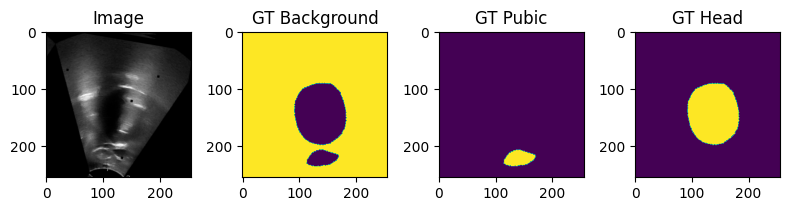

In [28]:
plot_img_mask_pred(train_dataset)

We could see that data transformation techniques are applied only to training set.

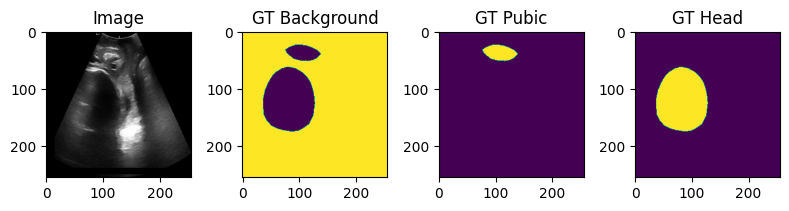

In [27]:
plot_img_mask_pred(val_dataset)

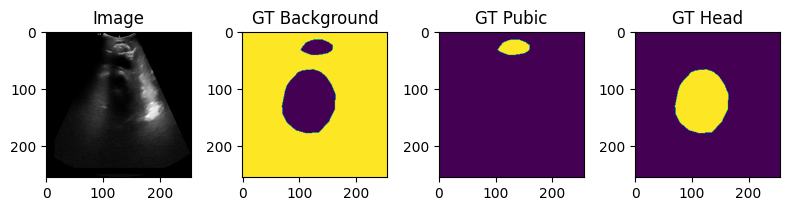

In [29]:
plot_img_mask_pred(test_dataset)

## U-Net Model

I am experimenting with various encoders, including `ResNet18`, `MIT-B0`, `DenseNet121`, `TIMM-ResNeSt14d`, and `TIMM-ResNeSt50d`, while also exploring different parameters such as `dropout` rate.



In [30]:
ENCODER = 'mit_b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'

AUX_PARAMS=dict(
    pooling='max',
    dropout=0.2,
    activation='softmax',
    classes=len(CLASSES),
)

In [43]:
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    decoder_attention_type=None,
    classes=len(CLASSES),
    activation=ACTIVATION,
    aux_params=AUX_PARAMS
)

preprocessing = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [44]:
model.classification_head = None

In [45]:
summary(model)

Layer (type:depth-idx)                        Param #
Unet                                          --
├─MixVisionTransformerEncoder: 1-1            --
│    └─OverlapPatchEmbed: 2-1                 --
│    │    └─Conv2d: 3-1                       4,736
│    │    └─LayerNorm: 3-2                    64
│    └─OverlapPatchEmbed: 2-2                 --
│    │    └─Conv2d: 3-3                       18,496
│    │    └─LayerNorm: 3-4                    128
│    └─OverlapPatchEmbed: 2-3                 --
│    │    └─Conv2d: 3-5                       92,320
│    │    └─LayerNorm: 3-6                    320
│    └─OverlapPatchEmbed: 2-4                 --
│    │    └─Conv2d: 3-7                       368,896
│    │    └─LayerNorm: 3-8                    512
│    └─ModuleList: 2-5                        --
│    │    └─Block: 3-9                        79,616
│    │    └─Block: 3-10                       79,616
│    └─LayerNorm: 2-6                         64
│    └─ModuleList: 2-7               

In [46]:
model = model.to(DEVICE)

## Training

I explored several loss functions, including `DiceLoss`, `JaccardLoss`, `SoftBCEWithLogitsLoss` (from the SMP library), as well as `CrossEntropyLoss` and `BCEWithLogitsLoss` (from torch.nn).

In [47]:
loss = SoftBCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

In [48]:
train_loss_lst, valid_loss_lst, valid_acc_lst =  [], [], []

In [49]:
train_loss_lst, valid_loss_lst, valid_acc_lst = train_model(model, NUM_EPOCHS, train_dataloader, val_dataloader,
                                                loss, optimizer, DEVICE, scheduler, 'train_loss')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 01/10 | Train Loss: 0.6154 | Validation Loss: 0.5879 | Validation Accuracy: 97.9%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 02/10 | Train Loss: 0.5818 | Validation Loss: 0.5777 | Validation Accuracy: 98.6%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 03/10 | Train Loss: 0.5770 | Validation Loss: 0.5748 | Validation Accuracy: 98.7%


  0%|          | 0/192 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d66ae064280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d66ae064280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 04/10 | Train Loss: 0.5748 | Validation Loss: 0.5733 | Validation Accuracy: 98.9%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 05/10 | Train Loss: 0.5737 | Validation Loss: 0.5722 | Validation Accuracy: 99.1%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 06/10 | Train Loss: 0.5731 | Validation Loss: 0.5721 | Validation Accuracy: 99.0%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 07/10 | Train Loss: 0.5725 | Validation Loss: 0.5715 | Validation Accuracy: 99.1%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 08/10 | Train Loss: 0.5722 | Validation Loss: 0.5716 | Validation Accuracy: 99.1%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 09/10 | Train Loss: 0.5719 | Validation Loss: 0.5709 | Validation Accuracy: 99.2%


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch: 10/10 | Train Loss: 0.5717 | Validation Loss: 0.5710 | Validation Accuracy: 99.1%


The plots I received for Loss and Accuracy

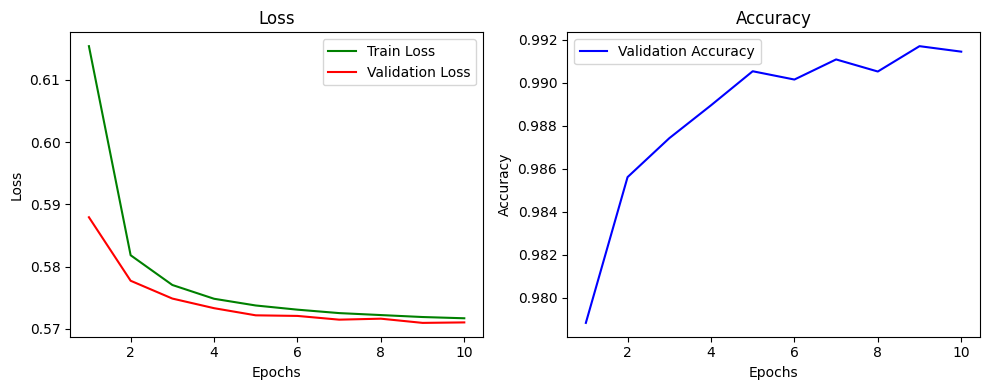

In [50]:
plot_loss_accuracy(train_loss_lst, valid_loss_lst, valid_acc_lst)

Saving model

In [22]:
model_name = "best_performance.pt"
save_path = base_dir + challenge_folder + f'/Saved Models/'
checkpoint_name = save_path + model_name

In [52]:
torch.save(model, checkpoint_name)

## Evaluating model

Load the model if needed

In [23]:
loaded_model = torch.load(checkpoint_name)
loaded_model.eval()
loaded_model = loaded_model.to(DEVICE)


In [53]:
model.eval()

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=32, o

The metrics that are used to analyze the performance of the model for this task are fundamental for image segmentation models.

1. **Sensitivity (True Positive Rate, Recall):**
   - Sensitivity measures the ability of a segmentation model to correctly identify positive instances.
   - Formula: Sensitivity = (True Positives) / (True Positives + False Negatives)

2. **Specificity:**
   - Specificity measures the ability of a segmentation model to correctly identify negative instances.
   - Formula: Specificity = (True Negatives) / (True Negatives + False Positives)

3. **Pixel Accuracy:**
   - Pixel accuracy assesses the overall correctness of pixel-wise predictions.
   - Formula: Pixel Accuracy = (Correctly Classified Pixels) / (Total Pixels)

4. **Jaccard Score (Intersection over Union, IoU):**
   - The Jaccard Score calculates the intersection over the union of the predicted and ground truth segmentation masks.
   - Formula: IoU = (Intersection) / (Union)

5. **Dice Score (F1 Score):**
   - The Dice Score measures the similarity between the predicted and ground truth masks.
   - Formula: Dice Score = (2 * True Positives) / (2 * True Positives + False Positives + False Negatives)

In [54]:
sensetivity, specificity, accuracy, jaccard, dice = check_metrics(test_dataloader, model, device=DEVICE)

Sensitivity: 0.986095
Specificity: 0.993068
Pixel Accuracy: 0.990744
Jaccard Score: 0.972709
Dice Score: 0.986115


The graphs below demonstrate the performance of the model for one of the test samples. They provide a visual comparison between the predicted mask and the ground truth one.

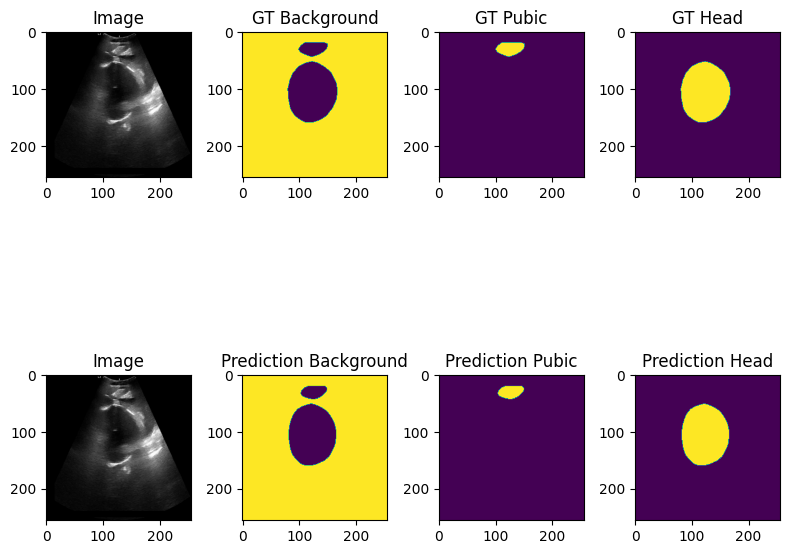

In [55]:
plot_img_mask_pred(test_dataset, plot_pred=True, model=model, device = DEVICE)

## Angle of Progression Estimation

Random pair image-mask from the test dataset

In [130]:
index = random.randint(0, len(test_dataset) - 1)

In [131]:
image = test_dataset[index][0].permute(1,2,0)
mask = test_dataset[index][1].permute(1,2,0)

Prediction

In [132]:
img_to_pred = test_dataset[index][0].unsqueeze(0).type(torch.float32).to(DEVICE)
pred = loaded_model(img_to_pred)
pred = pred.squeeze(0).cpu().detach().permute(1,2,0)
pred[pred < 0.5]=0
pred[pred > 0.5]=1

To numpy, change the shape

In [133]:
image = image.numpy()
mask = (mask[:,:,1] + mask[:,:,2]*2).numpy()
pred = (pred[:,:,1] + pred[:,:,2]*2).numpy()

Angle of Progression estimation

In [134]:
gt_aop, gt_aop_img = angle_of_progression_estimation(mask, return_img=True)
pred_aop, pred_aop_img = angle_of_progression_estimation(pred, return_img=True)

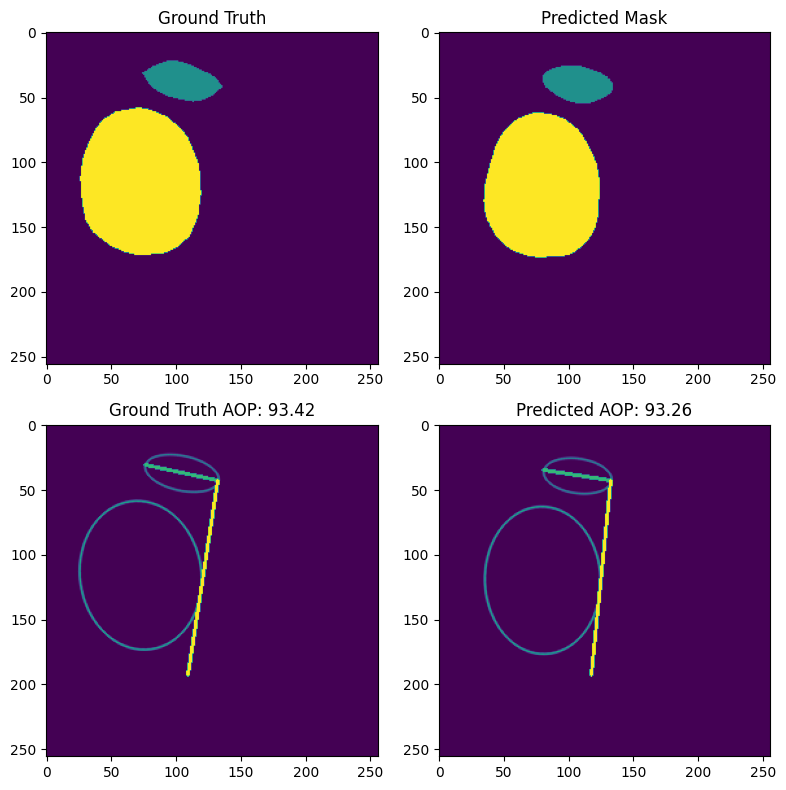

In [135]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(mask)
plt.title('Ground Truth')


plt.subplot(2, 2, 2)
plt.imshow(pred)
plt.title("Predicted Mask")

plt.subplot(2, 2, 3)
plt.imshow(gt_aop_img)
plt.title(f'Ground Truth AOP: {round(gt_aop, 2)}')

plt.subplot(2, 2, 4)
plt.imshow(pred_aop_img)
plt.title(f'Predicted AOP: {round(pred_aop, 2)}')

# Show the plots
plt.tight_layout()
plt.show()
